In [98]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [99]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader


In [100]:
import numpy as np
import matplotlib.pyplot as plt


In [101]:
batch_size = 32
learning_rate = 0.001
epoch = 15

cuda_available = torch.cuda.is_available()
device = torch.device('cuda' if cuda_available else 'cpu')

print('Current: ', device)

Current:  cuda


In [102]:
!nvidia-smi # gpu 확인

Thu Apr 25 15:53:15 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   77C    P0              31W /  70W |    249MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [103]:
train_data = datasets.MNIST(root = './data/train/',
                            train = True,
                            transform = transforms.ToTensor(),
                            download = True)
test_data = datasets.MNIST(root = './data/test/',
                            train = False,
                            transform = transforms.ToTensor(),
                            download = True)
train_loader = DataLoader(dataset = train_data,
                            batch_size = batch_size,
                            shuffle = True)
test_loader = DataLoader(dataset = test_data,
                            batch_size = batch_size,
                            shuffle = True)

In [104]:
class Convolution_Networks(nn.Module):
    def __init__(self):
        super(Convolution_Networks, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding='same')
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding='same')
        self.dropout = nn.Dropout2d(0.25)
        self.relu = nn.ReLU()
        self.max_pooling = nn.MaxPool2d(kernel_size = 2)
        self.fc1 = nn.Linear(7*7*64, 1000)
        self.fc2 = nn.Linear(1000, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.max_pooling(x)

        x = self.conv2(x)
        x = self.relu(x)
        x = self.max_pooling(x)

        x = self.dropout(x)
        x = torch.flatten(x, 1)

        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output


In [105]:
model = Convolution_Networks().cuda(device)

optimizer = optim.Adam(model.parameters(), lr = learning_rate)
criterion = nn.CrossEntropyLoss()

In [106]:
history = []
for e in range(epoch):
    i = 1
    epoch_loss = 0
    for data, target in train_loader:
        data = data.to(device)
        target = target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        if i % 500 == 0:
            print("Epoch {}, Train Step : {}\tLoss : {:3f}".format(e, i, loss.item()))
        i += 1
    epoch_loss /= (i-1)*batch_size
    print("Epoch {} end, Train Step : {}\t\t\tLoss : {:3f}".format(e, i, epoch_loss))
    history.append((e, epoch_loss))

Epoch 0, Train Step : 500	Loss : 0.046952
Epoch 0, Train Step : 1000	Loss : 0.044064
Epoch 0, Train Step : 1500	Loss : 0.031374
Epoch 0 end, Train Step : 1876			Loss : 0.004266
Epoch 1, Train Step : 500	Loss : 0.003684
Epoch 1, Train Step : 1000	Loss : 0.005847
Epoch 1, Train Step : 1500	Loss : 0.011020
Epoch 1 end, Train Step : 1876			Loss : 0.001506
Epoch 2, Train Step : 500	Loss : 0.146243
Epoch 2, Train Step : 1000	Loss : 0.040533
Epoch 2, Train Step : 1500	Loss : 0.001337
Epoch 2 end, Train Step : 1876			Loss : 0.001022
Epoch 3, Train Step : 500	Loss : 0.000244
Epoch 3, Train Step : 1000	Loss : 0.003765
Epoch 3, Train Step : 1500	Loss : 0.000875
Epoch 3 end, Train Step : 1876			Loss : 0.000818
Epoch 4, Train Step : 500	Loss : 0.005634
Epoch 4, Train Step : 1000	Loss : 0.004236
Epoch 4, Train Step : 1500	Loss : 0.000089
Epoch 4 end, Train Step : 1876			Loss : 0.000595
Epoch 5, Train Step : 500	Loss : 0.004688
Epoch 5, Train Step : 1000	Loss : 0.000309
Epoch 5, Train Step : 1500	Los

In [107]:
model.eval()
correct = 0
for data, target in test_loader:
    data = data.to(device)
    target = target.to(device)
    output = model(data)
    prediction = output.data.max(1)[1]
    correct += prediction.eq(target.data).sum()

acc = 100. * correct / len(test_loader.dataset)
print("Test set Accuracy : {:.2f}%".format(acc))

Test set Accuracy : 99.27%


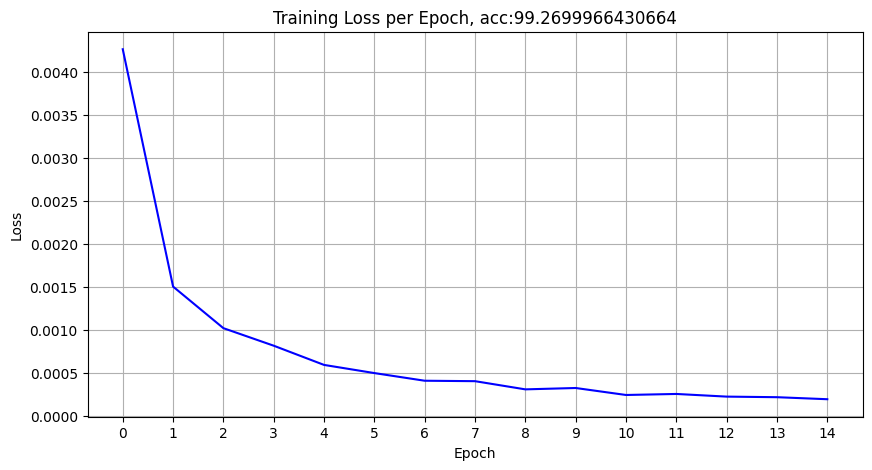

In [108]:

epochs = [x[0] for x in history]
losses = [x[1] for x in history]

plt.figure(figsize=(10, 5))
plt.plot(epochs, losses, linestyle='-', color='blue')
plt.title(f'Training Loss per Epoch, acc:{acc}')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.xticks(epochs)

plt.savefig('cnn_3_2_64.png')
plt.show()

In [109]:
import os

def createFolder(directory):
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSError:
        print ('Error: Creating directory. ' +  directory)

createFolder('/content/drive/MyDrive/Colab Notebooks/2024_1학기_멀티미디어설계')
createFolder('/content/drive/MyDrive/Colab Notebooks/2024_1학기_멀티미디어설계/HW4_models')

PATH = '/content/drive/MyDrive/Colab Notebooks/2024_1학기_멀티미디어설계/HW4_models/cnn_single_3_2_64.pt'

torch.save(model.state_dict(), PATH)

# 다회시행 자동화(cnn 조정)

Epoch 0 end, Train Step : 1876			Loss : 0.005604
Epoch 1 end, Train Step : 1876			Loss : 0.001860
Epoch 2 end, Train Step : 1876			Loss : 0.001191
Epoch 3 end, Train Step : 1876			Loss : 0.000797
Epoch 4 end, Train Step : 1876			Loss : 0.000584
Epoch 5 end, Train Step : 1876			Loss : 0.000488
Epoch 6 end, Train Step : 1876			Loss : 0.000386
Epoch 7 end, Train Step : 1876			Loss : 0.000312
Epoch 8 end, Train Step : 1876			Loss : 0.000251
Epoch 9 end, Train Step : 1876			Loss : 0.000232
Epoch 10 end, Train Step : 1876			Loss : 0.000203
Epoch 11 end, Train Step : 1876			Loss : 0.000175
Epoch 12 end, Train Step : 1876			Loss : 0.000204
Epoch 13 end, Train Step : 1876			Loss : 0.000161
Epoch 14 end, Train Step : 1876			Loss : 0.000170
Test set Accuracy : 98.86%


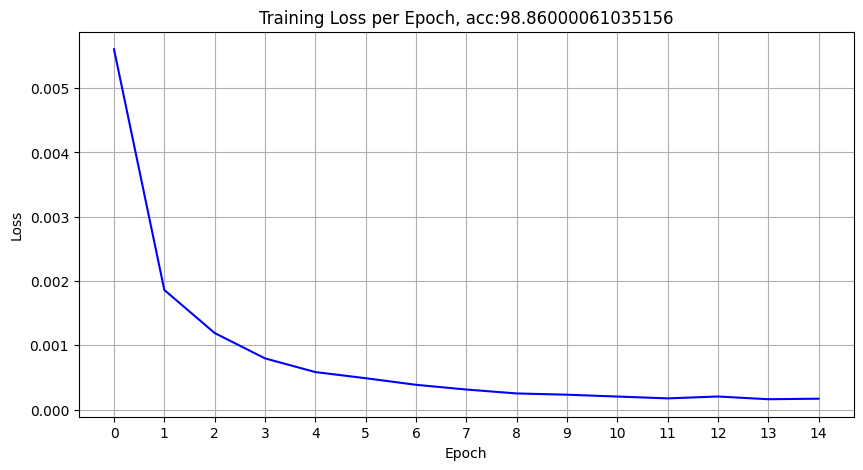

>>> 필터크기:3, cnn개수:1, 마지막 채널:32 : acc = 98.86000061035156
Epoch 0 end, Train Step : 1876			Loss : 0.005044
Epoch 1 end, Train Step : 1876			Loss : 0.001646
Epoch 2 end, Train Step : 1876			Loss : 0.000984
Epoch 3 end, Train Step : 1876			Loss : 0.000628
Epoch 4 end, Train Step : 1876			Loss : 0.000473
Epoch 5 end, Train Step : 1876			Loss : 0.000383
Epoch 6 end, Train Step : 1876			Loss : 0.000287
Epoch 7 end, Train Step : 1876			Loss : 0.000255
Epoch 8 end, Train Step : 1876			Loss : 0.000216
Epoch 9 end, Train Step : 1876			Loss : 0.000193
Epoch 10 end, Train Step : 1876			Loss : 0.000186
Epoch 11 end, Train Step : 1876			Loss : 0.000194
Epoch 12 end, Train Step : 1876			Loss : 0.000174
Epoch 13 end, Train Step : 1876			Loss : 0.000164
Epoch 14 end, Train Step : 1876			Loss : 0.000162
Test set Accuracy : 98.79%


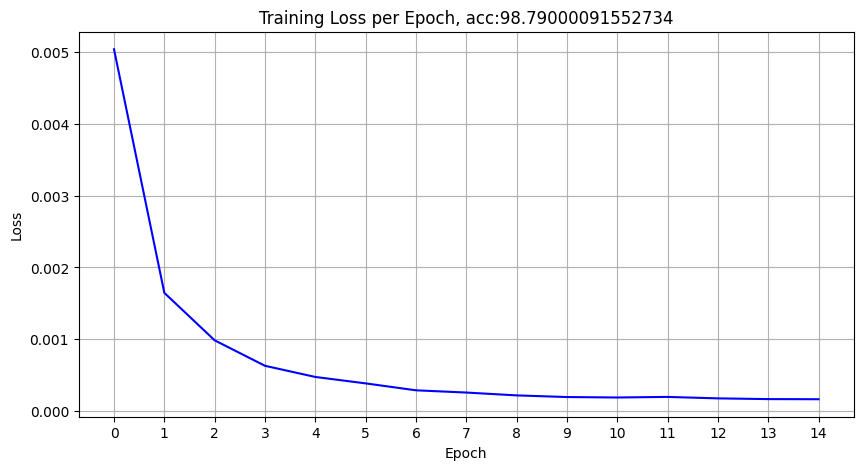

>>> 필터크기:3, cnn개수:1, 마지막 채널:64 : acc = 98.79000091552734
Epoch 0 end, Train Step : 1876			Loss : 0.005080
Epoch 1 end, Train Step : 1876			Loss : 0.001739
Epoch 2 end, Train Step : 1876			Loss : 0.001229
Epoch 3 end, Train Step : 1876			Loss : 0.000956
Epoch 4 end, Train Step : 1876			Loss : 0.000749
Epoch 5 end, Train Step : 1876			Loss : 0.000618
Epoch 6 end, Train Step : 1876			Loss : 0.000539
Epoch 7 end, Train Step : 1876			Loss : 0.000466
Epoch 8 end, Train Step : 1876			Loss : 0.000411
Epoch 9 end, Train Step : 1876			Loss : 0.000350
Epoch 10 end, Train Step : 1876			Loss : 0.000368
Epoch 11 end, Train Step : 1876			Loss : 0.000277
Epoch 12 end, Train Step : 1876			Loss : 0.000293
Epoch 13 end, Train Step : 1876			Loss : 0.000285
Epoch 14 end, Train Step : 1876			Loss : 0.000285
Test set Accuracy : 99.14%


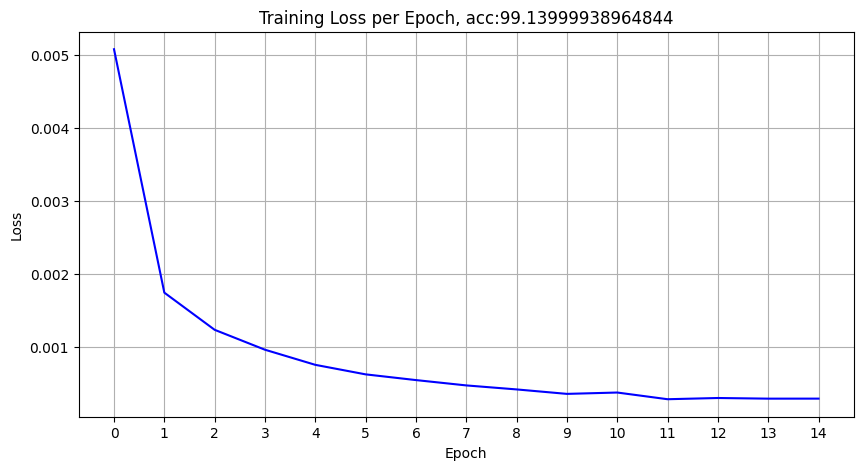

>>> 필터크기:3, cnn개수:2, 마지막 채널:32 : acc = 99.13999938964844
Epoch 0 end, Train Step : 1876			Loss : 0.004035
Epoch 1 end, Train Step : 1876			Loss : 0.001457
Epoch 2 end, Train Step : 1876			Loss : 0.000979
Epoch 3 end, Train Step : 1876			Loss : 0.000759
Epoch 4 end, Train Step : 1876			Loss : 0.000581
Epoch 5 end, Train Step : 1876			Loss : 0.000502
Epoch 6 end, Train Step : 1876			Loss : 0.000410
Epoch 7 end, Train Step : 1876			Loss : 0.000382
Epoch 8 end, Train Step : 1876			Loss : 0.000332
Epoch 9 end, Train Step : 1876			Loss : 0.000251
Epoch 10 end, Train Step : 1876			Loss : 0.000303
Epoch 11 end, Train Step : 1876			Loss : 0.000261
Epoch 12 end, Train Step : 1876			Loss : 0.000231
Epoch 13 end, Train Step : 1876			Loss : 0.000239
Epoch 14 end, Train Step : 1876			Loss : 0.000191
Test set Accuracy : 99.32%


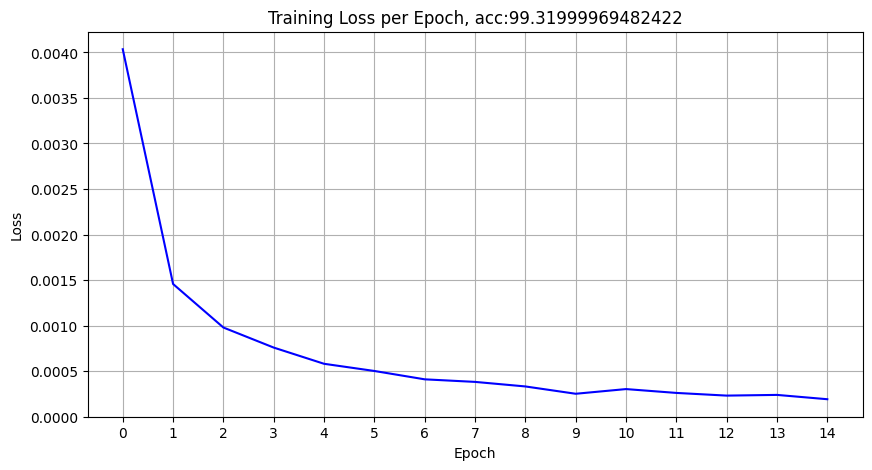

>>> 필터크기:3, cnn개수:2, 마지막 채널:64 : acc = 99.31999969482422
Epoch 0 end, Train Step : 1876			Loss : 0.005412
Epoch 1 end, Train Step : 1876			Loss : 0.001864
Epoch 2 end, Train Step : 1876			Loss : 0.001313
Epoch 3 end, Train Step : 1876			Loss : 0.001063
Epoch 4 end, Train Step : 1876			Loss : 0.000881
Epoch 5 end, Train Step : 1876			Loss : 0.000761
Epoch 6 end, Train Step : 1876			Loss : 0.000634
Epoch 7 end, Train Step : 1876			Loss : 0.000578
Epoch 8 end, Train Step : 1876			Loss : 0.000471
Epoch 9 end, Train Step : 1876			Loss : 0.000452
Epoch 10 end, Train Step : 1876			Loss : 0.000397
Epoch 11 end, Train Step : 1876			Loss : 0.000441
Epoch 12 end, Train Step : 1876			Loss : 0.000341
Epoch 13 end, Train Step : 1876			Loss : 0.000356
Epoch 14 end, Train Step : 1876			Loss : 0.000318
Test set Accuracy : 99.08%


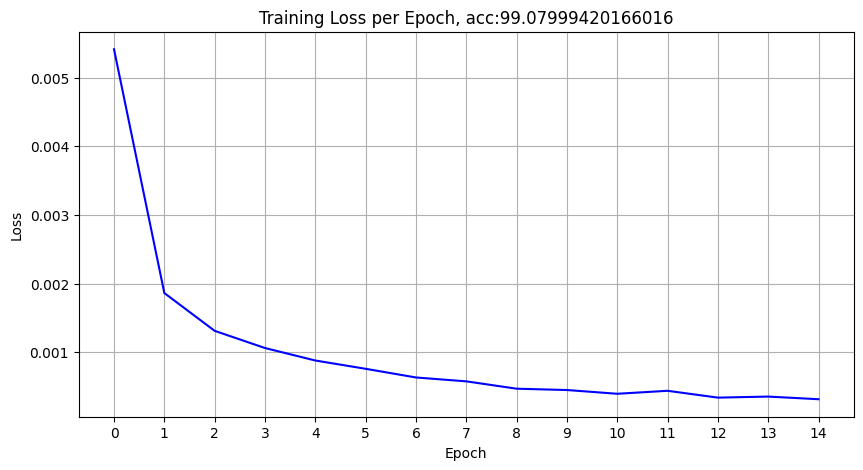

>>> 필터크기:3, cnn개수:3, 마지막 채널:32 : acc = 99.07999420166016
Epoch 0 end, Train Step : 1876			Loss : 0.004257
Epoch 1 end, Train Step : 1876			Loss : 0.001479
Epoch 2 end, Train Step : 1876			Loss : 0.001108
Epoch 3 end, Train Step : 1876			Loss : 0.000844
Epoch 4 end, Train Step : 1876			Loss : 0.000703
Epoch 5 end, Train Step : 1876			Loss : 0.000610
Epoch 6 end, Train Step : 1876			Loss : 0.000492
Epoch 7 end, Train Step : 1876			Loss : 0.000427
Epoch 8 end, Train Step : 1876			Loss : 0.000436
Epoch 9 end, Train Step : 1876			Loss : 0.000355
Epoch 10 end, Train Step : 1876			Loss : 0.000357
Epoch 11 end, Train Step : 1876			Loss : 0.000310
Epoch 12 end, Train Step : 1876			Loss : 0.000256
Epoch 13 end, Train Step : 1876			Loss : 0.000328
Epoch 14 end, Train Step : 1876			Loss : 0.000270
Test set Accuracy : 99.13%


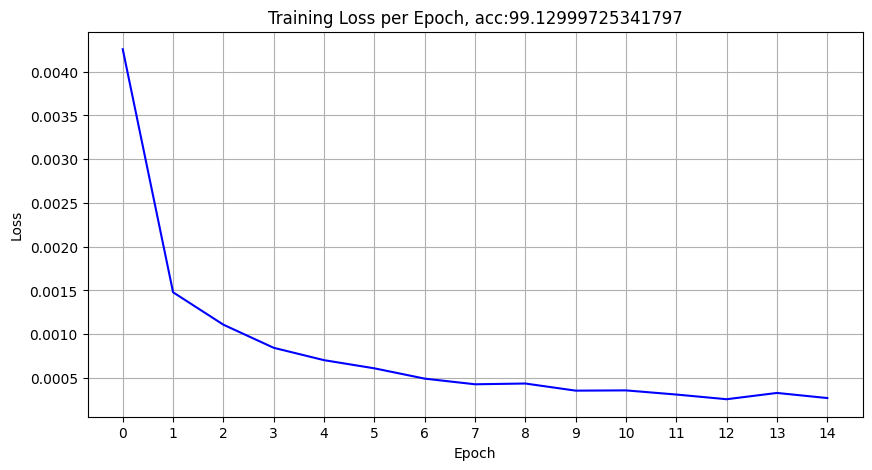

>>> 필터크기:3, cnn개수:3, 마지막 채널:64 : acc = 99.12999725341797


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:1040.)
  return F.conv2d(input, weight, bias, self.stride,


Epoch 0 end, Train Step : 1876			Loss : 0.004694
Epoch 1 end, Train Step : 1876			Loss : 0.001585
Epoch 2 end, Train Step : 1876			Loss : 0.001083
Epoch 3 end, Train Step : 1876			Loss : 0.000795
Epoch 4 end, Train Step : 1876			Loss : 0.000588
Epoch 5 end, Train Step : 1876			Loss : 0.000502
Epoch 6 end, Train Step : 1876			Loss : 0.000417
Epoch 7 end, Train Step : 1876			Loss : 0.000357
Epoch 8 end, Train Step : 1876			Loss : 0.000331
Epoch 9 end, Train Step : 1876			Loss : 0.000353
Epoch 10 end, Train Step : 1876			Loss : 0.000218
Epoch 11 end, Train Step : 1876			Loss : 0.000253
Epoch 12 end, Train Step : 1876			Loss : 0.000285
Epoch 13 end, Train Step : 1876			Loss : 0.000223
Epoch 14 end, Train Step : 1876			Loss : 0.000203
Test set Accuracy : 98.97%


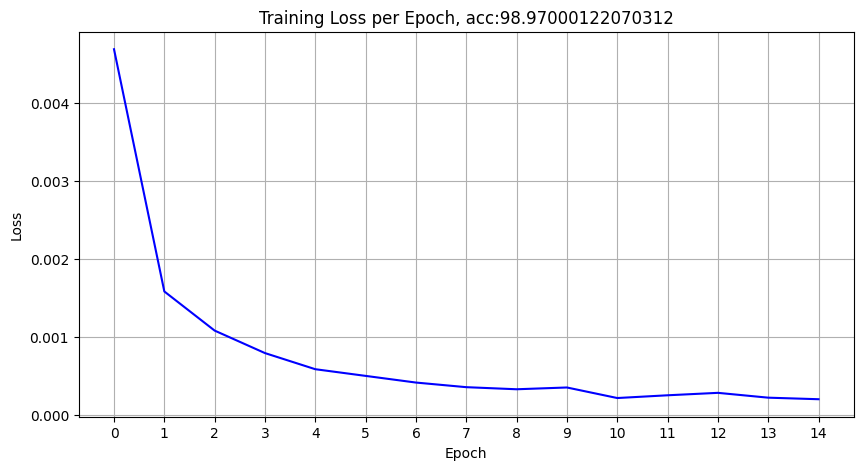

>>> 필터크기:6, cnn개수:1, 마지막 채널:32 : acc = 98.97000122070312
Epoch 0 end, Train Step : 1876			Loss : 0.004155
Epoch 1 end, Train Step : 1876			Loss : 0.001482
Epoch 2 end, Train Step : 1876			Loss : 0.000950
Epoch 3 end, Train Step : 1876			Loss : 0.000684
Epoch 4 end, Train Step : 1876			Loss : 0.000525
Epoch 5 end, Train Step : 1876			Loss : 0.000437
Epoch 6 end, Train Step : 1876			Loss : 0.000355
Epoch 7 end, Train Step : 1876			Loss : 0.000296
Epoch 8 end, Train Step : 1876			Loss : 0.000321
Epoch 9 end, Train Step : 1876			Loss : 0.000251
Epoch 10 end, Train Step : 1876			Loss : 0.000223
Epoch 11 end, Train Step : 1876			Loss : 0.000231
Epoch 12 end, Train Step : 1876			Loss : 0.000214
Epoch 13 end, Train Step : 1876			Loss : 0.000225
Epoch 14 end, Train Step : 1876			Loss : 0.000163
Test set Accuracy : 98.87%


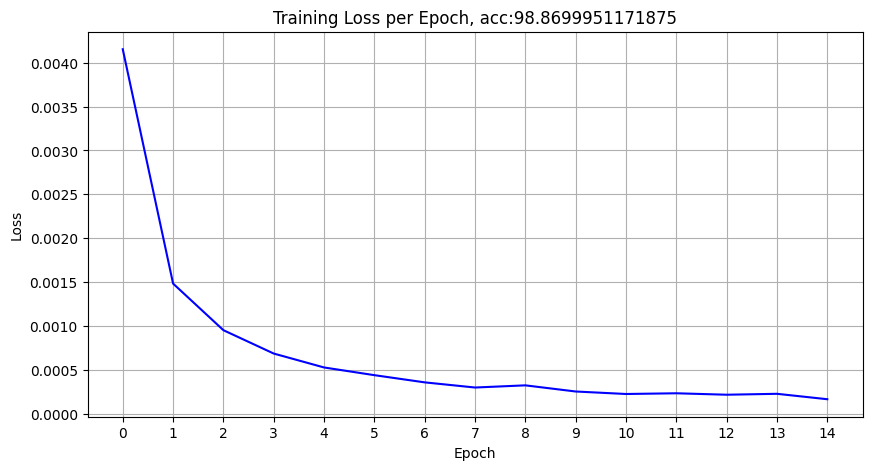

>>> 필터크기:6, cnn개수:1, 마지막 채널:64 : acc = 98.8699951171875
Epoch 0 end, Train Step : 1876			Loss : 0.004528
Epoch 1 end, Train Step : 1876			Loss : 0.001649
Epoch 2 end, Train Step : 1876			Loss : 0.001279
Epoch 3 end, Train Step : 1876			Loss : 0.000966
Epoch 4 end, Train Step : 1876			Loss : 0.000825
Epoch 5 end, Train Step : 1876			Loss : 0.000659
Epoch 6 end, Train Step : 1876			Loss : 0.000546
Epoch 7 end, Train Step : 1876			Loss : 0.000533
Epoch 8 end, Train Step : 1876			Loss : 0.000476
Epoch 9 end, Train Step : 1876			Loss : 0.000436
Epoch 10 end, Train Step : 1876			Loss : 0.000397
Epoch 11 end, Train Step : 1876			Loss : 0.000396
Epoch 12 end, Train Step : 1876			Loss : 0.000368
Epoch 13 end, Train Step : 1876			Loss : 0.000360
Epoch 14 end, Train Step : 1876			Loss : 0.000324
Test set Accuracy : 99.33%


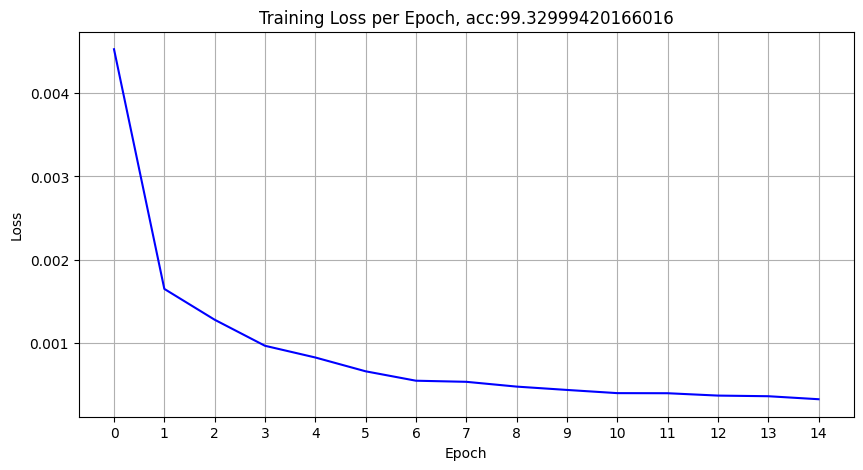

>>> 필터크기:6, cnn개수:2, 마지막 채널:32 : acc = 99.32999420166016
Epoch 0 end, Train Step : 1876			Loss : 0.003785
Epoch 1 end, Train Step : 1876			Loss : 0.001462
Epoch 2 end, Train Step : 1876			Loss : 0.001102
Epoch 3 end, Train Step : 1876			Loss : 0.000804
Epoch 4 end, Train Step : 1876			Loss : 0.000695
Epoch 5 end, Train Step : 1876			Loss : 0.000581
Epoch 6 end, Train Step : 1876			Loss : 0.000524
Epoch 7 end, Train Step : 1876			Loss : 0.000460
Epoch 8 end, Train Step : 1876			Loss : 0.000390
Epoch 9 end, Train Step : 1876			Loss : 0.000403
Epoch 10 end, Train Step : 1876			Loss : 0.000410
Epoch 11 end, Train Step : 1876			Loss : 0.000346
Epoch 12 end, Train Step : 1876			Loss : 0.000338
Epoch 13 end, Train Step : 1876			Loss : 0.000324
Epoch 14 end, Train Step : 1876			Loss : 0.000290
Test set Accuracy : 99.23%


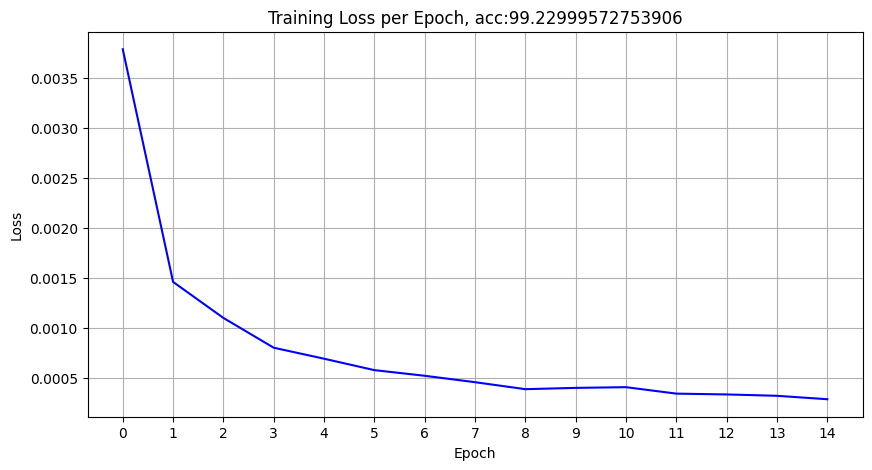

>>> 필터크기:6, cnn개수:2, 마지막 채널:64 : acc = 99.22999572753906
Epoch 0 end, Train Step : 1876			Loss : 0.004813
Epoch 1 end, Train Step : 1876			Loss : 0.001727
Epoch 2 end, Train Step : 1876			Loss : 0.001359
Epoch 3 end, Train Step : 1876			Loss : 0.001067
Epoch 4 end, Train Step : 1876			Loss : 0.000877
Epoch 5 end, Train Step : 1876			Loss : 0.000851
Epoch 6 end, Train Step : 1876			Loss : 0.000700
Epoch 7 end, Train Step : 1876			Loss : 0.000643
Epoch 8 end, Train Step : 1876			Loss : 0.000583
Epoch 9 end, Train Step : 1876			Loss : 0.000568
Epoch 10 end, Train Step : 1876			Loss : 0.000453
Epoch 11 end, Train Step : 1876			Loss : 0.000509
Epoch 12 end, Train Step : 1876			Loss : 0.000429
Epoch 13 end, Train Step : 1876			Loss : 0.000457
Epoch 14 end, Train Step : 1876			Loss : 0.000489
Test set Accuracy : 99.17%


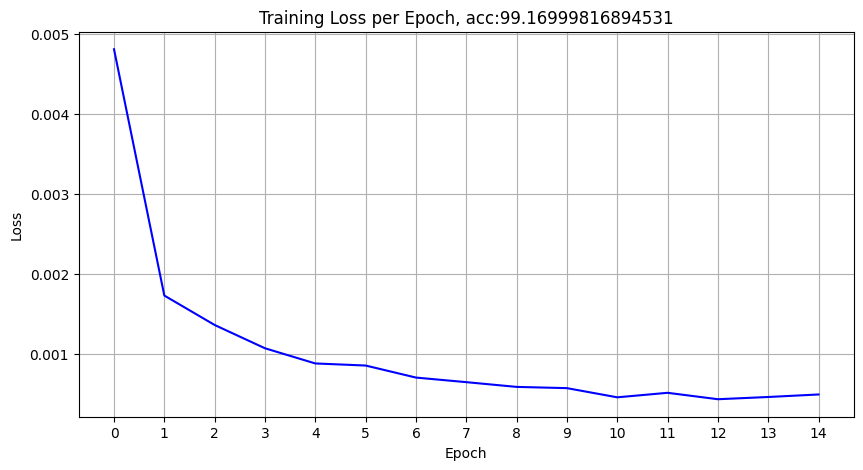

>>> 필터크기:6, cnn개수:3, 마지막 채널:32 : acc = 99.16999816894531
Epoch 0 end, Train Step : 1876			Loss : 0.004232
Epoch 1 end, Train Step : 1876			Loss : 0.001620
Epoch 2 end, Train Step : 1876			Loss : 0.001155
Epoch 3 end, Train Step : 1876			Loss : 0.000933
Epoch 4 end, Train Step : 1876			Loss : 0.000776
Epoch 5 end, Train Step : 1876			Loss : 0.000704
Epoch 6 end, Train Step : 1876			Loss : 0.000563
Epoch 7 end, Train Step : 1876			Loss : 0.000575
Epoch 8 end, Train Step : 1876			Loss : 0.000577
Epoch 9 end, Train Step : 1876			Loss : 0.000500
Epoch 10 end, Train Step : 1876			Loss : 0.000428
Epoch 11 end, Train Step : 1876			Loss : 0.000385
Epoch 12 end, Train Step : 1876			Loss : 0.000518
Epoch 13 end, Train Step : 1876			Loss : 0.000383
Epoch 14 end, Train Step : 1876			Loss : 0.000427
Test set Accuracy : 99.22%


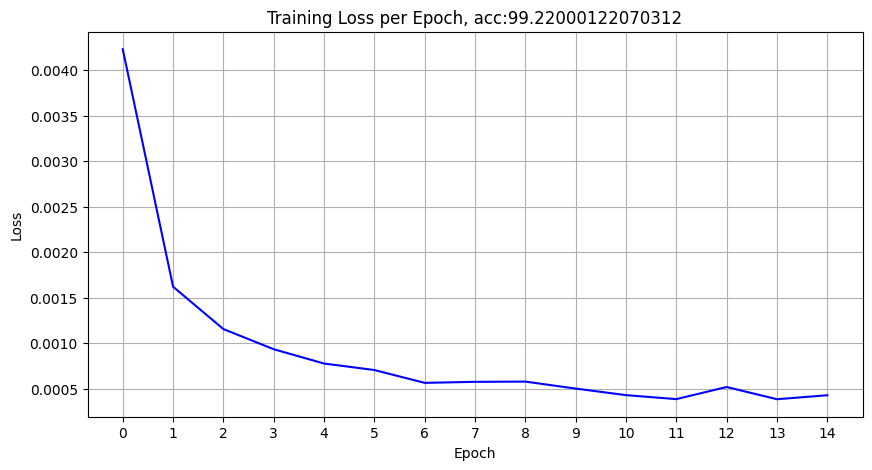

>>> 필터크기:6, cnn개수:3, 마지막 채널:64 : acc = 99.22000122070312
Epoch 0 end, Train Step : 1876			Loss : 0.004233
Epoch 1 end, Train Step : 1876			Loss : 0.001659
Epoch 2 end, Train Step : 1876			Loss : 0.001082
Epoch 3 end, Train Step : 1876			Loss : 0.000902
Epoch 4 end, Train Step : 1876			Loss : 0.000672
Epoch 5 end, Train Step : 1876			Loss : 0.000550
Epoch 6 end, Train Step : 1876			Loss : 0.000419
Epoch 7 end, Train Step : 1876			Loss : 0.000476
Epoch 8 end, Train Step : 1876			Loss : 0.000354
Epoch 9 end, Train Step : 1876			Loss : 0.000405
Epoch 10 end, Train Step : 1876			Loss : 0.000312
Epoch 11 end, Train Step : 1876			Loss : 0.000393
Epoch 12 end, Train Step : 1876			Loss : 0.000263
Epoch 13 end, Train Step : 1876			Loss : 0.000263
Epoch 14 end, Train Step : 1876			Loss : 0.000291
Test set Accuracy : 98.76%


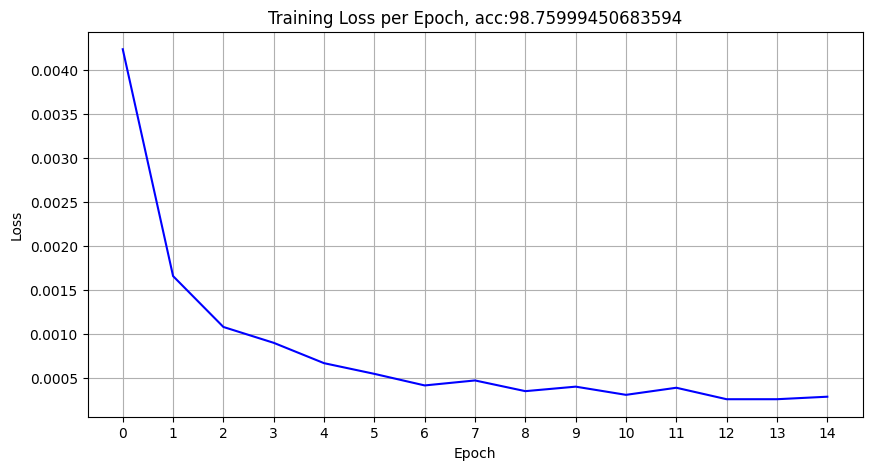

>>> 필터크기:9, cnn개수:1, 마지막 채널:32 : acc = 98.75999450683594
Epoch 0 end, Train Step : 1876			Loss : 0.003730
Epoch 1 end, Train Step : 1876			Loss : 0.001470
Epoch 2 end, Train Step : 1876			Loss : 0.001004
Epoch 3 end, Train Step : 1876			Loss : 0.000746
Epoch 4 end, Train Step : 1876			Loss : 0.000580
Epoch 5 end, Train Step : 1876			Loss : 0.000491
Epoch 6 end, Train Step : 1876			Loss : 0.000423
Epoch 7 end, Train Step : 1876			Loss : 0.000401
Epoch 8 end, Train Step : 1876			Loss : 0.000363
Epoch 9 end, Train Step : 1876			Loss : 0.000369
Epoch 10 end, Train Step : 1876			Loss : 0.000313
Epoch 11 end, Train Step : 1876			Loss : 0.000308
Epoch 12 end, Train Step : 1876			Loss : 0.000325
Epoch 13 end, Train Step : 1876			Loss : 0.000247
Epoch 14 end, Train Step : 1876			Loss : 0.000323
Test set Accuracy : 98.97%


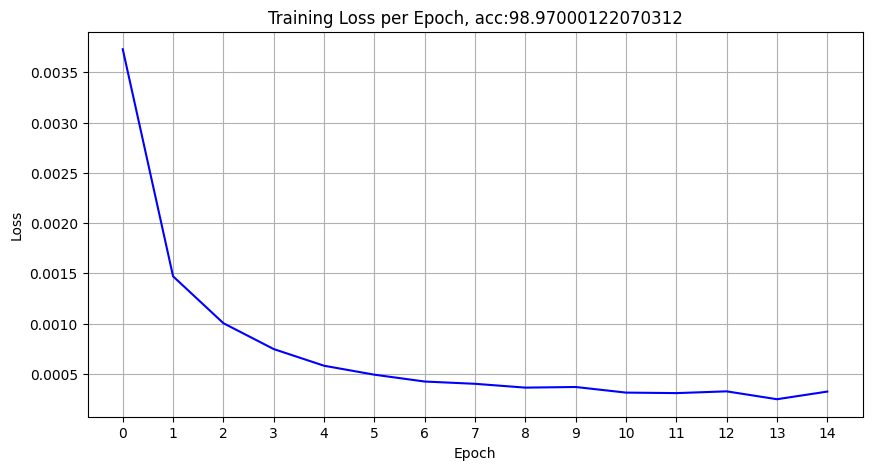

>>> 필터크기:9, cnn개수:1, 마지막 채널:64 : acc = 98.97000122070312
Epoch 0 end, Train Step : 1876			Loss : 0.004476
Epoch 1 end, Train Step : 1876			Loss : 0.001612
Epoch 2 end, Train Step : 1876			Loss : 0.001208
Epoch 3 end, Train Step : 1876			Loss : 0.000961
Epoch 4 end, Train Step : 1876			Loss : 0.000826
Epoch 5 end, Train Step : 1876			Loss : 0.000704
Epoch 6 end, Train Step : 1876			Loss : 0.000583
Epoch 7 end, Train Step : 1876			Loss : 0.000549
Epoch 8 end, Train Step : 1876			Loss : 0.000516
Epoch 9 end, Train Step : 1876			Loss : 0.000441
Epoch 10 end, Train Step : 1876			Loss : 0.000439
Epoch 11 end, Train Step : 1876			Loss : 0.000445
Epoch 12 end, Train Step : 1876			Loss : 0.000419
Epoch 13 end, Train Step : 1876			Loss : 0.000392
Epoch 14 end, Train Step : 1876			Loss : 0.000447
Test set Accuracy : 99.11%


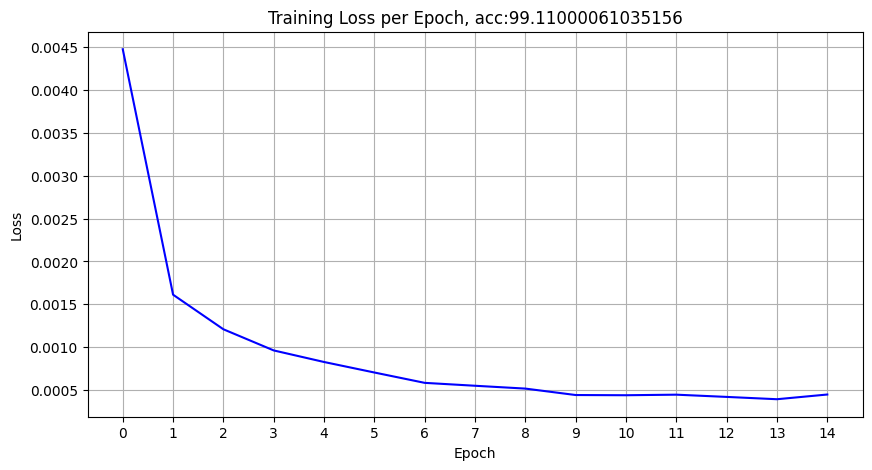

>>> 필터크기:9, cnn개수:2, 마지막 채널:32 : acc = 99.11000061035156
Epoch 0 end, Train Step : 1876			Loss : 0.003907
Epoch 1 end, Train Step : 1876			Loss : 0.001517
Epoch 2 end, Train Step : 1876			Loss : 0.001114
Epoch 3 end, Train Step : 1876			Loss : 0.000868
Epoch 4 end, Train Step : 1876			Loss : 0.000753
Epoch 5 end, Train Step : 1876			Loss : 0.000664
Epoch 6 end, Train Step : 1876			Loss : 0.000533
Epoch 7 end, Train Step : 1876			Loss : 0.000592
Epoch 8 end, Train Step : 1876			Loss : 0.000376
Epoch 9 end, Train Step : 1876			Loss : 0.000449
Epoch 10 end, Train Step : 1876			Loss : 0.000455
Epoch 11 end, Train Step : 1876			Loss : 0.000479
Epoch 12 end, Train Step : 1876			Loss : 0.000351
Epoch 13 end, Train Step : 1876			Loss : 0.000391
Epoch 14 end, Train Step : 1876			Loss : 0.000329
Test set Accuracy : 98.96%


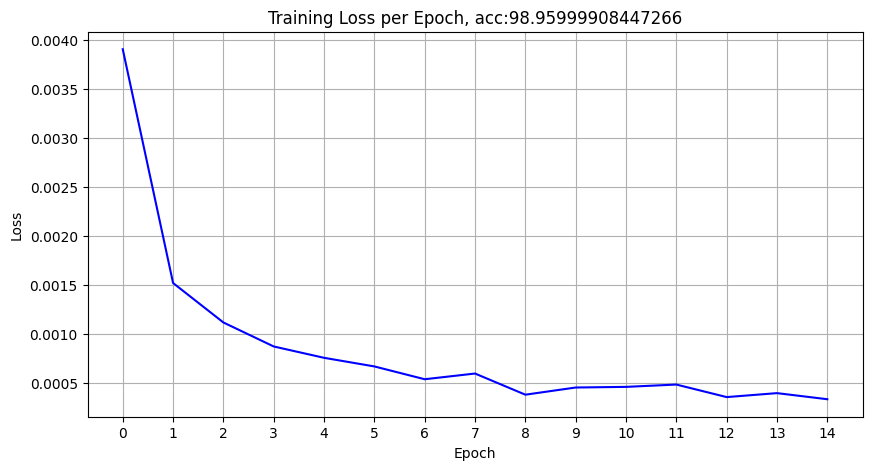

>>> 필터크기:9, cnn개수:2, 마지막 채널:64 : acc = 98.95999908447266
Epoch 0 end, Train Step : 1876			Loss : 0.005323
Epoch 1 end, Train Step : 1876			Loss : 0.001921
Epoch 2 end, Train Step : 1876			Loss : 0.001443
Epoch 3 end, Train Step : 1876			Loss : 0.001220
Epoch 4 end, Train Step : 1876			Loss : 0.001064
Epoch 5 end, Train Step : 1876			Loss : 0.000951
Epoch 6 end, Train Step : 1876			Loss : 0.000828
Epoch 7 end, Train Step : 1876			Loss : 0.000772
Epoch 8 end, Train Step : 1876			Loss : 0.000741
Epoch 9 end, Train Step : 1876			Loss : 0.000686
Epoch 10 end, Train Step : 1876			Loss : 0.000665
Epoch 11 end, Train Step : 1876			Loss : 0.000618
Epoch 12 end, Train Step : 1876			Loss : 0.000667
Epoch 13 end, Train Step : 1876			Loss : 0.000624
Epoch 14 end, Train Step : 1876			Loss : 0.000601
Test set Accuracy : 99.01%


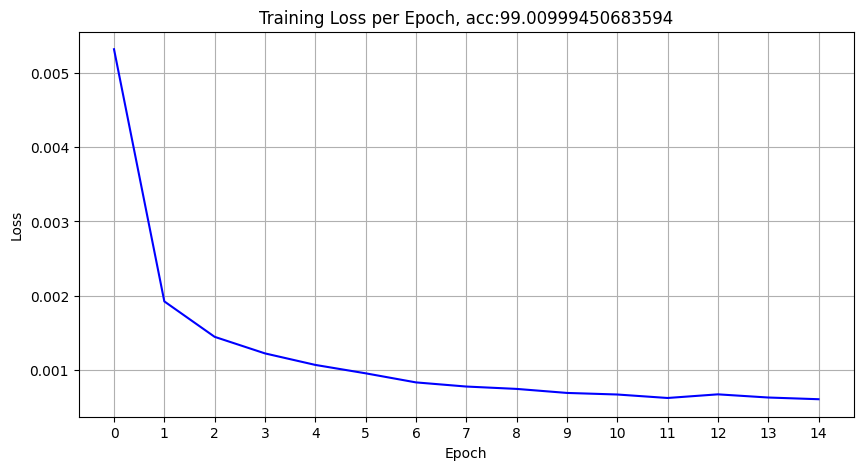

>>> 필터크기:9, cnn개수:3, 마지막 채널:32 : acc = 99.00999450683594
Epoch 0 end, Train Step : 1876			Loss : 0.004607
Epoch 1 end, Train Step : 1876			Loss : 0.001654
Epoch 2 end, Train Step : 1876			Loss : 0.001320
Epoch 3 end, Train Step : 1876			Loss : 0.001027
Epoch 4 end, Train Step : 1876			Loss : 0.000942
Epoch 5 end, Train Step : 1876			Loss : 0.000757
Epoch 6 end, Train Step : 1876			Loss : 0.000735
Epoch 7 end, Train Step : 1876			Loss : 0.000730
Epoch 8 end, Train Step : 1876			Loss : 0.000730
Epoch 9 end, Train Step : 1876			Loss : 0.000569
Epoch 10 end, Train Step : 1876			Loss : 0.000583
Epoch 11 end, Train Step : 1876			Loss : 0.000511
Epoch 12 end, Train Step : 1876			Loss : 0.000560
Epoch 13 end, Train Step : 1876			Loss : 0.000546
Epoch 14 end, Train Step : 1876			Loss : 0.000564
Test set Accuracy : 98.91%


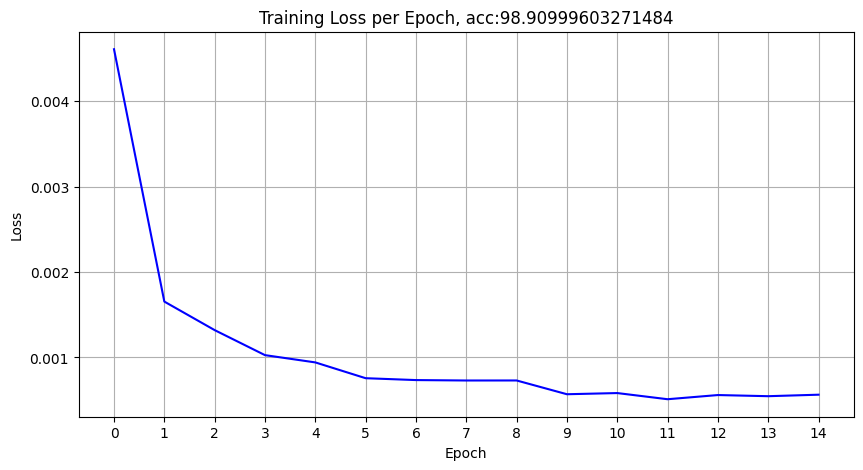

>>> 필터크기:9, cnn개수:3, 마지막 채널:64 : acc = 98.90999603271484


In [ ]:
kernel_num_list = [3, 6, 9]
cnn_num_list = [1, 2, 3]
last_channel_list = [32, 64]


for kernel_num in kernel_num_list:
    for cnn_num in cnn_num_list:
        for last_channel in last_channel_list:

            class Convolution_Networks(nn.Module):
                def __init__(self):
                    super(Convolution_Networks, self).__init__()
                    if(cnn_num == 1):
                        self.conv1 = nn.Conv2d(in_channels=1, out_channels=last_channel, kernel_size=kernel_num, stride=1, padding='same')
                    elif cnn_num == 2:
                        self.conv1 = nn.Conv2d(in_channels=1, out_channels=last_channel//2, kernel_size=kernel_num, stride=1, padding='same')
                        self.conv2 = nn.Conv2d(in_channels=last_channel//2, out_channels=last_channel, kernel_size=kernel_num, stride=1, padding='same')
                    elif cnn_num == 3:
                        self.conv1 = nn.Conv2d(in_channels=1, out_channels=(last_channel//2)//2, kernel_size=kernel_num, stride=1, padding='same')
                        self.conv2 = nn.Conv2d(in_channels=(last_channel//2)//2, out_channels=last_channel//2, kernel_size=kernel_num, stride=1, padding='same')
                        self.conv3 = nn.Conv2d(in_channels=last_channel//2, out_channels=last_channel, kernel_size=kernel_num, stride=1, padding='same')
                    self.dropout = nn.Dropout2d(0.25)
                    self.relu = nn.ReLU()
                    self.max_pooling = nn.MaxPool2d(kernel_size = 2)
                    if cnn_num>1:
                        self.fc1 = nn.Linear(7*7*last_channel, 1000)
                    else:
                        self.fc1 = nn.Linear(14*14*last_channel, 1000)
                    self.fc2 = nn.Linear(1000, 10)

                def forward(self, x):
                    x = self.conv1(x)
                    x = self.relu(x)
                    x = self.max_pooling(x)

                    if(cnn_num >= 2):
                        x = self.conv2(x)
                        x = self.relu(x)
                        x = self.max_pooling(x)

                    if(cnn_num >= 3):
                        x = self.conv3(x)
                        x = self.relu(x)

                    x = self.dropout(x)
                    x = torch.flatten(x, 1)

                    x = self.fc1(x)
                    x = self.relu(x)
                    x = self.fc2(x)
                    output = F.log_softmax(x, dim=1)
                    return output


            model = Convolution_Networks().cuda(device)

            optimizer = optim.Adam(model.parameters(), lr = learning_rate)
            criterion = nn.CrossEntropyLoss()


            history = []
            for e in range(epoch):
                i = 1
                epoch_loss = 0
                for data, target in train_loader:
                    data = data.to(device)
                    target = target.to(device)
                    optimizer.zero_grad()
                    output = model(data)
                    loss = criterion(output, target)
                    loss.backward()
                    optimizer.step()
                    epoch_loss += loss.item()
                    i += 1
                epoch_loss /= (i-1)*batch_size
                print("Epoch {} end, Train Step : {}\t\t\tLoss : {:3f}".format(e, i, epoch_loss))
                history.append((e, epoch_loss))


            model.eval()
            correct = 0
            for data, target in test_loader:
                data = data.to(device)
                target = target.to(device)
                output = model(data)
                prediction = output.data.max(1)[1]
                correct += prediction.eq(target.data).sum()

            acc = 100. * correct / len(test_loader.dataset)
            print("Test set Accuracy : {:.2f}%".format(acc))


            epochs = [x[0] for x in history]
            losses = [x[1] for x in history]

            plt.figure(figsize=(10, 5))
            plt.plot(epochs, losses, linestyle='-', color='blue')
            plt.title(f'Training Loss per Epoch, acc:{acc}')
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.grid(True)
            plt.xticks(epochs)

            plt.savefig(f'/content/drive/MyDrive/Colab Notebooks/2024_1학기_멀티미디어설계/HW4_models/cnn_{kernel_num}_{cnn_num}_{last_channel}.png')
            plt.show()


            PATH = f'/content/drive/MyDrive/Colab Notebooks/2024_1학기_멀티미디어설계/HW4_models/cnn_{kernel_num}_{cnn_num}_{last_channel}.pt'

            torch.save(model.state_dict(), PATH)
            print(f'>>> 필터크기:{kernel_num}, cnn개수:{cnn_num}, 마지막 채널:{last_channel} : acc = {acc}')

# pt model_dict 불러오기

In [110]:
# 로드하는 모델 정보에 따라 코드 수정 필요
k = 6
class Convolution_Networks(nn.Module):
    def __init__(self):
        super(Convolution_Networks, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=k, stride=1, padding='same')
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=k, stride=1, padding='same')

        self.dropout = nn.Dropout2d(0.25)
        self.relu = nn.ReLU()
        self.max_pooling = nn.MaxPool2d(kernel_size = 2)
        self.fc1 = nn.Linear(7*7*32, 1000)
        self.fc2 = nn.Linear(1000, 10)
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.max_pooling(x)

        x = self.conv2(x)
        x = self.relu(x)
        x = self.max_pooling(x)

        x = self.dropout(x)
        x = torch.flatten(x, 1)

        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output


model = Convolution_Networks().cuda(device)

model_dict = torch.load(f'/content/drive/MyDrive/Colab Notebooks/2024_1학기_멀티미디어설계/HW4_models/CNN_계수_임동훈.pt')
model.load_state_dict(model_dict)

<All keys matched successfully>

In [111]:
model.eval()
correct = 0
for data, target in test_loader:
    data = data.to(device)
    target = target.to(device)
    output = model(data)
    prediction = output.data.max(1)[1]
    correct += prediction.eq(target.data).sum()

acc = 100. * correct / len(test_loader.dataset)
print("Test set Accuracy : {:.2f}%".format(acc))


Test set Accuracy : 99.33%


# CNN kernel 시각화

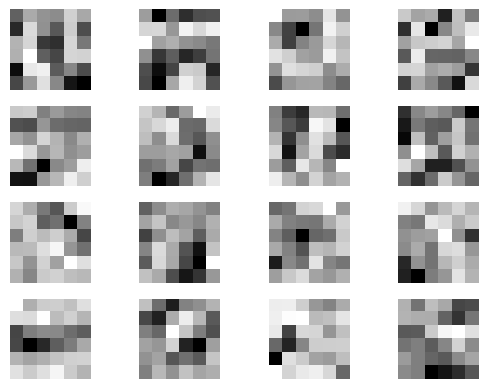

In [112]:
kernel = model.conv1.weight.data.cpu().numpy()

num_kernels = kernel.shape[0]

fig, axes = plt.subplots(nrows=int(np.sqrt(num_kernels)), ncols=int(np.sqrt(num_kernels)))
for i, ax in enumerate(axes.flat):
    ax.imshow(kernel[i, 0], cmap='gray')
    ax.axis('off')
plt.show()


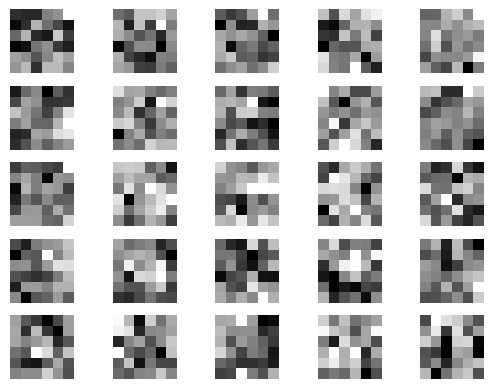

In [122]:
kernel = model.conv2.weight.data.cpu().numpy()

num_kernels = kernel.shape[0]

fig, axes = plt.subplots(nrows=int(np.sqrt(num_kernels)), ncols=int(np.sqrt(num_kernels)))
for i, ax in enumerate(axes.flat):
    ax.imshow(kernel[i, 0], cmap='gray')
    ax.axis('off')
plt.show()


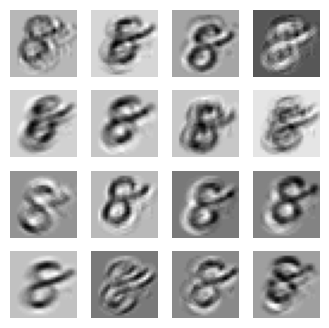

In [114]:
# feature map 시각화
import torch
import matplotlib.pyplot as plt
import numpy as np

def get_feature_maps(model, layer_name, input_image):
    feature_maps = []
    def hook_fn(module, input, output):
        feature_maps.append(output)
    hook = getattr(model, layer_name).register_forward_hook(hook_fn)
    model(input_image)
    hook.remove()
    return feature_maps[0]

test_loader_iter = iter(test_loader)
images, labels = next(test_loader_iter)
input_image = images[0].unsqueeze(0).to(device)

feature_maps = get_feature_maps(model, 'conv1', input_image)
feature_maps_np = feature_maps.data.cpu().numpy()

fig, axes = plt.subplots(4, 4, figsize=(4, 4))
for i, ax in enumerate(axes.flat):
    if i < feature_maps_np.shape[1]:
        ax.imshow(feature_maps_np[0, i], cmap='gray')
        ax.axis('off')
    else:
        ax.axis('off')
plt.show()
